#Introdução



##Descrição e Regras do Jogo de Xadrez:

O xadrez é um jogo de tabuleiro estratégico e tático para dois jogadores, cada um controlando um conjunto de peças coloridas (brancas e pretas) em um tabuleiro de 64 casas quadradas alternadamente claras e escuras, organizadas em oito fileiras e oito colunas. O objetivo do jogo é dar xeque-mate ao rei do adversário, o que significa que o rei está em uma posição onde não pode se mover sem ser capturado.

As peças no tabuleiro são:

1.  Rei: Pode mover-se uma casa em qualquer direção.
2.  Dama (ou Rainha): Pode mover-se em qualquer direção (horizontal, vertical ou diagonal) por várias casas.
3.  Torre: Move-se horizontal ou verticalmente por várias casas.
4.  Bispo: Move-se diagonalmente por várias casas.
5.  Cavalo: Move-se em forma de "L", duas casas em uma direção e uma casa perpendicular a essa.
6.  Peão: Move-se para frente uma casa, exceto no primeiro movimento, onde pode avançar duas casas; captura peças diagonalmente.


Além disso, existem regras especiais, como o "roque" (movimento que envolve o rei e uma torre) e a promoção do peão (quando alcança a última fileira, pode ser promovido a outra peça).

O jogo começa com as peças posicionadas de maneira específica, e os jogadores alternam seus movimentos, tentando controlar o centro do tabuleiro, desenvolver suas peças e criar oportunidades táticas para atacar o rei adversário enquanto protegem o seu próprio.



##Tipo de jogo.
Ele é um jogo completamente Observável ja aque os dois agente tem visão do jogo todo.

Deterministico devido cada estado do ambiente é definido puramente pelas ações do agente.

Sequencial e estático pois uma movimento jogado agora afeta um proximo movimento e o agente tem todo tempo do mundo(ou quase) para escolher o proximo movimento.

Mesmo o xadrez possuindo 900^40 jogos de xadrez possiveis. Aproximandamente 10^120 o que é maior que a estimativa de atomos no universo 6x10^79. Ele ainda é considerado discreto.

##Solução

No contexto do xadrez, o algoritmo Minimax é uma escolha comum para determinar a melhor jogada a ser feita por um jogador. No entanto, devido à complexidade do xadrez e à quantidade de jogadas possíveis, o Minimax é geralmente combinado com a poda alfa-beta para tornar a busca mais eficiente. A poda alfa-beta reduz o número de ramos da árvore que precisam ser explorados, descartando ramos que já se sabe que não levarão a uma solução melhor do que a já encontrada.

O algoritmo Minimax avalia as jogadas possíveis até uma certa profundidade na árvore de busca, usando uma função de avaliação para determinar a vantagem de um estado do tabuleiro. Essa função pode levar em consideração fatores como material, posição das peças, segurança do rei, entre outros. O objetivo é encontrar a jogada que leva a um estado onde a vantagem do jogador seja maximizada, considerando que o oponente também busca minimizar essa vantagem.

Essa abordagem de usar o Minimax com poda alfa-beta e uma função de avaliação bem projetada é uma das maneiras eficazes de abordar o problema de encontrar a melhor jogada no xadrez.


In [1]:
!pip3 install python-chess
!pip3 install cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.0-py3-none-any.whl size=148469 sha256=505baa6b6fcc22ff447548c7ca54d6c4f1417aaede8df1e11356ba9ea8f963d6
  Stored in directory: /root/.cache/pip/wheels/46/0b/07/0a760d1eb7bd47ad727299125255ca757eb468db2d0f41db57
Successfully built chess
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00


In [2]:
import chess
from chess import Board
import chess.svg
import cairosvg
from cairosvg import svg2png
from collections import OrderedDict
from operator import itemgetter
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
import cv2
from google.colab.patches import cv2_imshow
from abc import ABC, abstractmethod
from random import choice
from itertools import count
from time import sleep

Config de pontos

In [3]:
BOARD_SCORES = {
    "PAWN": 1,
    "BISHOP": 5,
    "KING": 0,
    "QUEEN": 10,
    "KNIGHT": 3,
    "ROOK": 4
}

Board

In [4]:
def draw_board(current_board):
  """Draw board

   Keyword arguments:
   current_board -- chess.Board()
  """

  # fica bonito mais que come um recurso danado.
  clear_output(wait=True)
  board_img = chess.svg.board(current_board, flipped = True)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = cv2.imread('/content/board.png', 1)
  cv2_imshow(img)

# como o nome diz checa se deu empate ou se ocorreu algum problema no board.
def check_tie(board: Board, claim_draw: bool = False) -> bool:
    tie = (board.is_stalemate() or
           board.is_fivefold_repetition() or
           board.is_insufficient_material())
    if claim_draw:
        tie = tie or board.can_claim_draw()
    if tie:
        return True
    return False

def eval_board_state(board, player: bool, board_scores_policy: dict) -> float:
    total_score = 0
    for piece, score in board_scores_policy.items():
        piece = getattr(chess, piece)

        true_score = len(board.pieces(piece, player)) * score

        false_score = len(board.pieces(piece, not player)) * score * -1

        total_score += (true_score + false_score)

    return total_score

def game_score(board, player, board_scores_policy=BOARD_SCORES) -> float:
    score = eval_board_state(board, player, board_scores_policy)

    if board.is_checkmate() and board.turn == (not player):
        score = 100
    elif board.is_checkmate() and board.turn == player:
        score = -100

    return score


Game Engine

In [5]:
class Game:
    def __init__(self, board: Board = None):
        self.board = Board()
        self.draw = True

    def _game(self, white_p, black_p, pause=1):
        board = self.board.copy()
        result = None

        for i in count():
            sleep(pause)

            if self.draw:
              draw_board(board)
            else:
              print(board)

            if board.turn:
              print(white_p.solver)
            else:
              print(black_p.solver)

            if board.is_game_over(claim_draw=True):
                break

            if board.turn:
                move = white_p.move(board)
            else:
                move = black_p.move(board)

            board.push_uci(move)

        result_stat = {
            "white": white_p.solver,
            "black": black_p.solver,
            "FEN": board.fen(),
            "last_move": board.peek(),
            "moves_history": [move.uci() for move in board.move_stack],
        }

        return result_stat

    def start_game(self, p1_cls, p2_cls, pause=1):
        result = self._game(p1_cls(True), p2_cls(False), pause)
        return result

    # OBS: usar somente para test em massa
    def start_games(self, p1_cls, p2_cls, n=10):
        for i in range(n):
            if(choice([True, False])):
              result = self.start_game(p1_cls, p2_cls)
            else:
              result = self.start_game(p1_cls, p2_cls)
            print(result)

Base and Random Player

In [6]:
class Player(ABC):
    def __init__(self, player: bool, solver: str = None):
        self.player = player
        self.solver = solver

    @abstractmethod
    def move(self, board: Board):
        pass


# WARNING: PLAYER aleatorio original do codigo
class RandomPlayer(Player):
    def __init__(self, player: bool):
        super().__init__(player, "random")

    def move(self, board: Board) -> str:
        assert board.turn == self.player, "Not bot turn to move!"

        moves = list(board.legal_moves)
        move = choice(moves).uci()

        return move


Greddy

In [7]:
# WARNING: PLAYER Ganancioso sempre escolhe o melhor primeiro movimento.
class GreedyPlayer(Player):
    def __init__(self, player: bool):
        super().__init__(player, "greedy")

    def move(self, board: Board) -> str:
        moves = list(board.legal_moves)

        for move in moves:
            board.push(move)
            move.score = game_score(board, self.player)
            board.pop()

        moves = sorted(moves, key=lambda move: move.score, reverse=True)

        return moves[0].uci()

MinMax player

In [8]:

# WARNING: PLAYER minimo e maximo sempre escolhe o melhor primeiro movimento e melhor movimento do outro player.
class MiniMaxPlayer(Player):
    def __init__(self, player, depth=3):
        super().__init__(player, "minimax")
        self.depth = depth

    def minimax(self, board, player: bool, depth: int):
        # se for branca primeiro movimento
        if len(board.move_stack) == 0:
            moves = list(board.legal_moves)
            white_opening = choice(moves)
            return [0.0, white_opening]

        return self._minimax(board, player, depth - 1, -10000, 10000)

    def _minimax(self, board: Board, player: bool, depth: int, alpha, beta):
        # confere se é continua a afundar ou se acabou por profundidade ou game over.
        if depth == 0 or board.is_game_over(claim_draw=False):
            return [game_score(board, self.player), None]

        # com base no player escolhe a melhor ou pior jogada
        if board.turn == player:
            return self._max(alpha, beta, board, depth, player)
        else:
            return self._min(alpha, beta, board, depth, player)

    def _max(self, alpha, beta, board, depth, player):
        max_score, best_move = -9999, None
        moves = list(board.legal_moves)
        for move in moves:

            board.push(move)
            score = self._minimax(board, not player, depth - 1, alpha, beta)
            board.pop()

            # adaptado para poda alfa
            alpha = max(alpha, score[0])
            if beta <= alpha:
                break

            if score[0] >= max_score:
                max_score = score[0]
                best_move = move

        return [max_score, best_move]

    def _min(self, alpha, beta, board, depth, player):
        min_score, best_move = 9999, None
        moves = list(board.legal_moves)
        for move in moves:

            board.push(move)
            score = self._minimax(board, not player, depth - 1, alpha, beta)
            board.pop()

            # adaptado para poda beta
            beta = min(beta, score[0])
            if beta <= alpha:
                break

            if score[0] <= min_score:
                min_score = score[0]
                best_move = move

        return [min_score, best_move]

    def move(self, board: Board) -> str:
        # pq isso existe vc me pergunta é para deixar mais inteligente essa batata sem custar um ano de vida
        # ponto a ressaltar jogadas impares são mais adequadas que jogadas pares.
        # count_moves = len(list(board.legal_moves))
        # if count_moves >= 10:
        #   self.depth = 3
        # else:
        #   self.depth = 5

        best_move = self.minimax(board, self.player, self.depth)
        return best_move[1].uci()


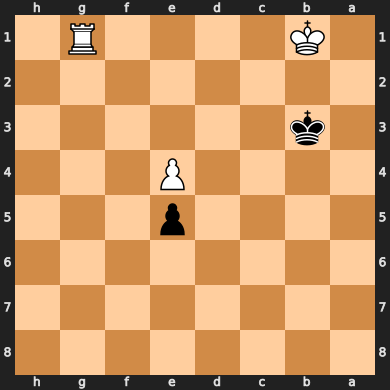

minimax
{'white': 'minimax', 'black': 'minimax', 'FEN': '8/8/8/4p3/4P3/1k6/8/1K4R1 b - - 13 34', 'last_move': Move.from_uci('a1b1'), 'moves_history': ['b1a3', 'a7a5', 'b2b4', 'a5b4', 'c2c4', 'b4a3', 'c1a3', 'a8a3', 'd2d4', 'a3a2', 'a1a2', 'b7b5', 'c4b5', 'c7c5', 'b5c6', 'd7c6', 'e2e4', 'd8d4', 'd1d4', 'e7e5', 'd4e5', 'c8e6', 'e5e6', 'f7e6', 'f2f4', 'g7g5', 'f4g5', 'h7h5', 'g5h6', 'f8h6', 'g2g4', 'c6c5', 'h2h4', 'c5c4', 'f1c4', 'e6e5', 'c4g8', 'h8g8', 'g4g5', 'h6g5', 'h4g5', 'g8g5', 'e1d1', 'g5g1', 'h1g1', 'b8a6', 'a2a6', 'e8d7', 'd1c1', 'd7c7', 'c1b1', 'c7b7', 'b1a1', 'b7a6', 'a1b1', 'a6a5', 'b1a1', 'a5a4', 'a1b1', 'a4a3', 'b1a1', 'a3b3', 'a1b1', 'b3a3', 'b1a1', 'a3b3', 'a1b1']}


In [9]:
game = Game()
result = game.start_game(MiniMaxPlayer,MiniMaxPlayer, pause=0.3)
print(result)

#Conclusão


##pontos de Observação sobre este algorithmo:

porque é ruim meu MinMax:

1.   olha poucas jogadas na frente (default:3) quando mais jogadas na frente melhor ele irá atuar
2.   como eu não fiz calculo de posicionalmento das peças em geral ele se move de forma aleatoria (dummy) e tem preferencia de matar algumas peças em vez de criar estrategias para checkmate.
3. o algoritmo de poda alfa-beta é pouco desenvolvido(muito dummy) e podendo ser removido e adaptado por soluções mais adedaquadas economizando tempo de processamento.





##pontos que valem resaltar:

1.  pq node default 4, simples ele não entregar peças de graça a seu oponente e incentivar o uso de pastorzinho (jogada de xadrez)
2.  se fosse adicionado um processo asyncrono em tempo de carregamento da tela e processamento seria a linha perfeita.

#Referencias Utilizadas para criar o Projeto:
https://colab.research.google.com/github/iAmEthanMai/chess-engine-model/blob/main/python_chess_engine.ipynb#scrollTo=GFvB8_SHg0V5 acessado ontem(12/05/2024)

https://github.com/lamesjim/Chess-AI/tree/master acesso em 04/05/2024

https://medium.freecodecamp.com/simple-chess-ai-step-by-step-1d55a9266977 acessado em 23/04/2024

https://www.geeksforgeeks.org/minimax-algorithm-in-game-theory-set-1-introduction/ acessado em 04/05/2024

https://github.com/Howuhh/chess_minimax.git acessado ontem(12/05/2024)